In [1]:
from loadmodules import *
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.colors as mcolors
import scipy as sp
import matplotlib.ticker as ticker
from skimage.feature import peak_local_max
from skimage import io, color

%matplotlib inline
rcParams['figure.facecolor'] = 'white'

In [2]:
parent_dir = './level4/'

simulation_list = sorted([directory for directory in os.listdir(parent_dir) if 'Au06' in directory and 'cfea' in directory])

print(simulation_list)
simulation_list = [simulation_list[5], simulation_list[2]]
print(simulation_list)

['Au06_cfea_bheffect', 'Au06_cfea_cemosaics', 'Au06_cfea_compressive', 'Au06_cfea_emosaics', 'Au06_cfea_fiducial', 'Au06_cfea_scbase', 'Au06_cfea_sh100myr10', 'Au06_cfea_sh100myr50', 'Au06_cfea_sh200myr10', 'Au06_cfea_sh50myr10', 'Au06_cfea_sh50myr50', 'old_Au06_cfea_sh100myr10', 'old_Au06_cfea_sh200myr10', 'old_Au06_cfea_sh50myr10', 'old_Au06_cfea_sh50myr50']
['Au06_cfea_scbase', 'Au06_cfea_compressive']


In [3]:
exp_list = np.genfromtxt('AREPO_CONFIG/param_files/ExpansionList_128', delimiter=' ')

In [4]:
proj = auriga_projection()
proj.add_directory([parent_dir, parent_dir], simulation_list)

path,halos= ['./level4/', './level4/'] ['Au06_cfea_scbase', 'Au06_cfea_compressive']
halos= ['Au06_cfea_scbase', 'Au06_cfea_compressive']
Found 128 snapshots for halo ./level4//Au06_cfea_scbase.
Found 128 snapshots for halo ./level4//Au06_cfea_compressive.
directories= [<projections_load.auriga_directory object at 0x7fba9e96b4c0>]


In [5]:
ids_stars_w_scs = []
age_stars_w_scs = []

for sim in simulation_list:
    sf = load_subfind(127, dir=parent_dir+sim+'/output/', hdf5=True, loadonly=['fpos', 'fmm2', 'frc2', 'svel', 'flty', 'fnsh', 'slty', 'spos', 'smty', 'ffsh'] )
    s = gadget_readsnap(127, snappath=parent_dir+sim+'/output/', subfind=sf, hdf5=True, loadonlytype=[4], loadonlyhalo=0)

    mask = s.data['incl'] > 0
    ids_stars_w_scs.append(s.data['id'][mask])
    age_stars_w_scs.append(s.data['age'][mask])

In [ ]:
ncols=2
nrows=1
figsize=6.
boxsize=0.05
numthreads=8
res=128

for isnap in range(30, 127):
    f = plt.figure( FigureClass=sfig, figsize=( figsize*ncols, figsize*1.5*nrows ) )
    proj.select_halos_from_snapnum(isnap+1, loadonlytype=[0,4,5], loadonlyhalo=0, loadonly=['id','pos','vol','rho','mass','vel', 'vol','gsph'] )
    tcolor='w'
    print('Selected snapshot number:', proj.selected_snapnums[0])
    for isi, sn in enumerate(proj):
        mask_snap = (age_stars_w_scs[isi] > exp_list[isnap,0]) * (age_stars_w_scs[isi] <= exp_list[isnap+1,0])
        sn.calc_sf_indizes( sn.subfind, absolutesubnum=True)
        print('Selecting halo without merger tree of most bound DM particle information.')
        sn.select_halo( sn.subfind, rotate_disk=True, do_rotation=True, use_principal_axis=True)
        ax, ax2, x, y, y2, area = create_axis( f, isi, ncol=ncols, res=res, boxsize=boxsize, cb=True )
        ax, ax2 = projfuncs["gas_density"]( sn, f, ax, ax2, area, x, y, y2, isi, boxsize=boxsize, numthreads=numthreads, res=res, projflag=True, cosmo=proj.cosmo )
        pix_per_kpc = boxsize / (x.max() - x.min())
        pix_per_kpc_h1 = boxsize / (y.max() - y.min())
        pix_per_kpc_h2 = 0.5*boxsize / (y2.max() - y2.min())
        if isi == 0:
            barlen = 0.01 * pix_per_kpc
            asb = AnchoredSizeBar(ax.transData,
                                    barlen,
                                    r"$\rm{10\, kpc}$",
                                    fontproperties=fm.FontProperties(size=20, family='monospace'),
                                    loc=3,
                                    pad=0.2, borderpad=0.2, sep=10, color=tcolor,
                                    frameon=False)
            ax.add_artist(asb)
            ax.text( 0.05, 0.92, "$\\rm{Baseline}$", color=tcolor, fontsize=20, transform=ax.transAxes)
        else:
            time = sn.cosmology_get_lookback_time_from_a(sn.time, is_flat=True)
            print('Adding time to plot.')
            ax.text( 0.65, 0.92, "$\\rm{t=%1.1f\,Gyr}$" % (time), color=tcolor, fontsize=20, transform=ax.transAxes )
            ax.text( 0.8, 0.05, "$\\rm{Halo \, 6}$", color=tcolor, fontsize=20, transform=ax.transAxes)
            ax.text( 0.05, 0.92, "$\\rm{Compressive}$", color=tcolor, fontsize=20, transform=ax.transAxes)

        mask_id = np.isin(sn.data['id'][sn.data['subhalo']==0], ids_stars_w_scs[isi][mask_snap])
        xpos = sn.data['pos'][sn.data['subhalo']==0][mask_id,2]
        ypos = sn.data['pos'][sn.data['subhalo']==0][mask_id,1]
        zpos = sn.data['pos'][sn.data['subhalo']==0][mask_id,0]

        ax.scatter(xpos/pix_per_kpc, -ypos/pix_per_kpc_h1, marker='x', s=10, facecolors='k', alpha=0.4)
        ax2.scatter(xpos/pix_per_kpc, -zpos/pix_per_kpc_h2, marker='x', s=10, facecolors='k', alpha=0.4)

        ax.set(xlim=(-0.5*boxsize, 0.5*boxsize), ylim=(-0.5*boxsize, 0.5*boxsize))
        ax2.set(xlim=(-0.5*boxsize, 0.5*boxsize), ylim=(-0.25*boxsize, 0.25*boxsize))
    plt.show()
    # plt.savefig('plots/halo_6_scsbrith/base_comp_snap_{:2d}'.format(isnap)+'.png')

select_haloes_from_snapnum
Selected snapshot number: 71
There is subfind data
Selecting halo without merger tree of most bound DM particle information.
galrad= 0.011325753
Found 271420 stars.
Rotated pos.
Rotated vel.
s= 4.5
Selected 682464 of 2006317 particles.
nz= 256 zdist=0.025, boxx=0.050000, boxy=0.05
Total is  110536166.34621301
Selected 618265 of 2006317 particles.
nz= 256 zdist=0.025, boxx=0.050000, boxy=0.025


/users/aripcont/.local/lib/python3.10/site-packages/projections.py:52: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  cax.set_xticklabels(["$\\rm{10^{%d}}$"%ticks for ticks in np.log10(xticks)])


Total is  200374920.39955822
There is subfind data
Selecting halo without merger tree of most bound DM particle information.
galrad= 0.011325753
Found 271420 stars.
Rotated pos.
Rotated vel.
s= 4.5
Selected 682464 of 2006317 particles.
nz= 256 zdist=0.025, boxx=0.050000, boxy=0.05
Total is  110536166.34621301
Selected 618265 of 2006317 particles.
nz= 256 zdist=0.025, boxx=0.050000, boxy=0.025
Total is  200374920.39955822
Adding time to plot.
select_haloes_from_snapnum
Selected snapshot number: 90
There is subfind data
Selecting halo without merger tree of most bound DM particle information.
galrad= 0.015789015
Found 880704 stars.
Rotated pos.
Rotated vel.
s= 4.5
Selected 641685 of 2343623 particles.
nz= 256 zdist=0.025, boxx=0.050000, boxy=0.05
Total is  105588570.50275715
Selected 565668 of 2343623 particles.
nz= 256 zdist=0.025, boxx=0.050000, boxy=0.025


/users/aripcont/.local/lib/python3.10/site-packages/projections.py:52: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  cax.set_xticklabels(["$\\rm{10^{%d}}$"%ticks for ticks in np.log10(xticks)])


Total is  186137828.3051995
There is subfind data
Selecting halo without merger tree of most bound DM particle information.
galrad= 0.015789015
Found 880704 stars.
Rotated pos.
Rotated vel.
s= 4.5
Selected 641685 of 2343623 particles.
nz= 256 zdist=0.025, boxx=0.050000, boxy=0.05
Total is  105588570.50275715
Selected 565668 of 2343623 particles.
nz= 256 zdist=0.025, boxx=0.050000, boxy=0.025
Total is  186137828.3051995
Adding time to plot.


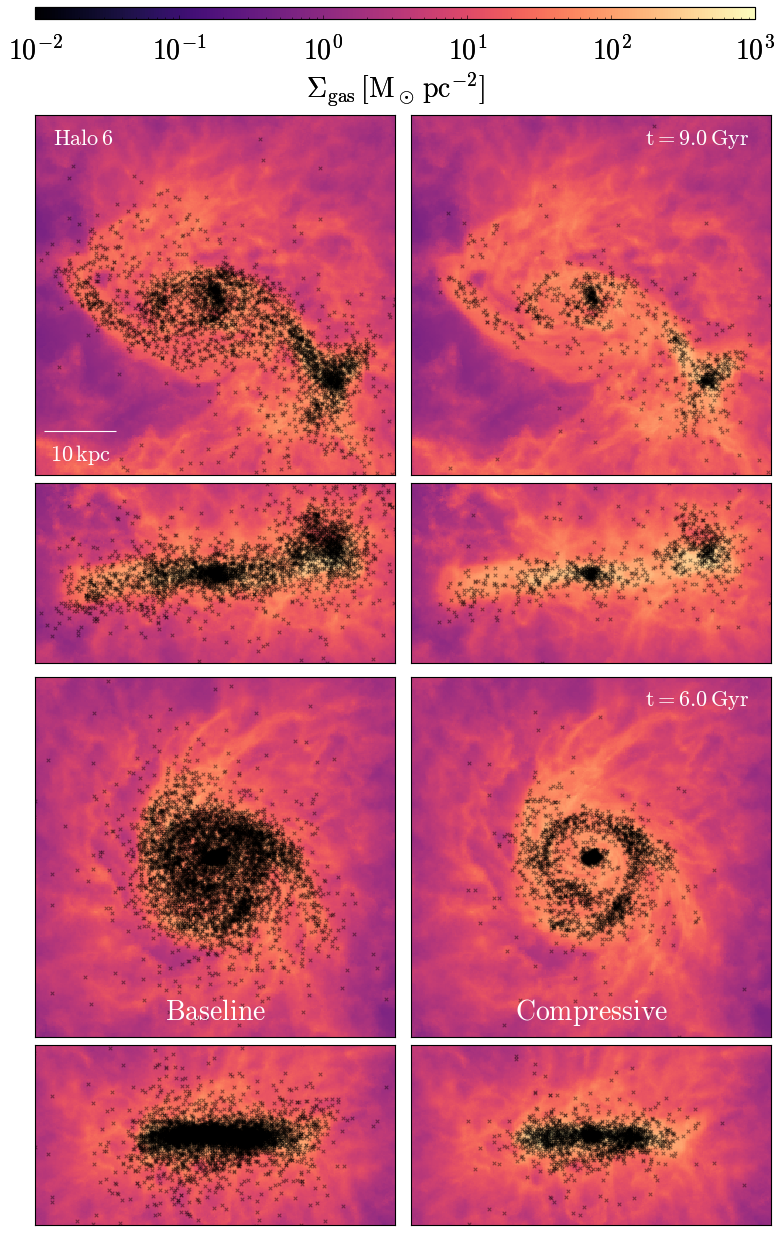

In [70]:
ncols=2
nrows=2
figsize=6.
boxsize=0.05
numthreads=8
res=256

f = plt.figure(FigureClass=sfig, figsize=(figsize*ncols, figsize*1.5*nrows))
for irow, isnap in enumerate([70, 89]):
    proj.select_halos_from_snapnum(isnap+1, loadonlytype=[0,4,5], loadonlyhalo=0, loadonly=['id','pos','vol','rho','mass','vel', 'vol','gsph'])
    tcolor = 'w'
    print('Selected snapshot number:', proj.selected_snapnums[0])
    for icol, sn in enumerate(proj):
        mask_snap = (age_stars_w_scs[icol] > exp_list[isnap,0]) * (age_stars_w_scs[icol] <= exp_list[isnap+1,0])
        sn.calc_sf_indizes(sn.subfind, absolutesubnum=True)

        print('Selecting halo without merger tree of most bound DM particle information.')
        sn.select_halo(sn.subfind, rotate_disk=True, do_rotation=True, use_principal_axis=True)
        
        ax, ax2, x, y, y2, area = create_axis(f, icol + irow*ncols, ncol=ncols, res=res, boxsize=boxsize, cb=~irow)
        if (irow == 1):
            pos = ax.get_position()
            ax.set_position([
                pos.x0,
                pos.y0 - 0.015,  # shift down
                pos.width,
                pos.height
            ])
            pos = ax2.get_position()
            ax2.set_position([
                pos.x0,
                pos.y0 - 0.015,  # shift down
                pos.width,
                pos.height
            ])

        ax, ax2 = projfuncs["gas_density"](sn, f, ax, ax2, area, x, y, y2, icol, boxsize=boxsize, numthreads=numthreads, res=res, projflag=True, cosmo=proj.cosmo)
        
        pix_per_kpc = boxsize / (x.max() - x.min())
        pix_per_kpc_h1 = boxsize / (y.max() - y.min())
        pix_per_kpc_h2 = 0.5*boxsize / (y2.max() - y2.min())

        if (irow == 0 and icol==0):
            ax.text(0.05, 0.92, "$\\rm{Halo \, 6}$", color=tcolor, fontsize=20, transform=ax.transAxes)
            barlen = 0.01 * pix_per_kpc
            asb = AnchoredSizeBar(ax.transData,
                                  barlen,
                                  r"$\rm{10\, kpc}$",
                                  fontproperties=fm.FontProperties(size=20, family='monospace'),
                                  loc=3,
                                  pad=0.2, borderpad=0.2, sep=10, color=tcolor,
                                  frameon=False)
            ax.add_artist(asb)

        if (irow == 1):
            if (icol == 0):
                ax.text(0.5, 0.05, "$\\rm{Baseline}$", color=tcolor, fontsize=25, ha='center', transform=ax.transAxes)
            else:
                ax.text(0.5, 0.05, "$\\rm{Compressive}$", color=tcolor, fontsize=25, ha='center', transform=ax.transAxes)
        
        if (icol == 1):
            print('Adding time to plot.')
            time = sn.cosmology_get_lookback_time_from_a(sn.time, is_flat=True)
            ax.text(0.65, 0.92, "$\\rm{t=%1.1f\,Gyr}$" % (time), color=tcolor, fontsize=20, transform=ax.transAxes)

        mask_id = np.isin(sn.data['id'][sn.data['subhalo']==0], ids_stars_w_scs[icol][mask_snap])
        xpos = sn.data['pos'][sn.data['subhalo']==0][mask_id,2]
        ypos = sn.data['pos'][sn.data['subhalo']==0][mask_id,1]
        zpos = sn.data['pos'][sn.data['subhalo']==0][mask_id,0]

        ax.scatter(xpos/pix_per_kpc, -ypos/pix_per_kpc_h1, marker='x', s=10, facecolors='k', alpha=0.4)
        ax2.scatter(xpos/pix_per_kpc, -zpos/pix_per_kpc_h2, marker='x', s=10, facecolors='k', alpha=0.4)

        ax.set(xlim=(-0.5*boxsize, 0.5*boxsize), ylim=(-0.5*boxsize, 0.5*boxsize))
        ax2.set(xlim=(-0.5*boxsize, 0.5*boxsize), ylim=(-0.25*boxsize, 0.25*boxsize))

plt.savefig('./plots/scs_birthloc_paper.pdf', bbox_inches='tight')